In [1]:
# Initial imports and notebook setup, click arrow to show
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy
from tqdm import tqdm

# Do Precautionary Motives Explain China's High Saving Rate?

The notebook [Nondurables-During-Great-Recession](http://econ-ark.org/notebooks/) shows that the collapse in consumer spending in the U.S. during the Great Recession could easily have been caused by a moderate and plausible increase in the degree of uncertainty.

But that exercise might make you worry that invoking difficult-to-measure "uncertainty" can explain anything (e.g. "the stock market fell today because the risk aversion of the representative agent increased").

The next exercise is designed to show that there are limits to the phenomena that can be explained by invoking plausible changes in uncertainty.

The specific question is whether a high degree of uncertainty can explain China's very high saving rate (approximately 25 percent), as some papers have proposed.  Specifically, we ask "what beliefs about uncertainty would Chinese consumers need to hold in order to generate a saving rate of 25 percent, given the rapid pace of Chinese growth?"

### The Thought Experiment

In more detail, our consumers will initially live in a stationary, low-growth environment (intended to approximate China before 1978).  Then, unexpectedly, income growth will surge at the same time that income uncertainty increases (intended to approximate the effect of economic reforms in China since 1978.)  Consumers believe the high-growth, high-uncertainty state is highly persistent, but that ultimately growth will slow to a "normal" pace matching that of other advanced countries.


### The Baseline Model

We want the model to have these elements:
1. "Standard" infinite horizon consumption/savings model, with mortality and permanent and temporary shocks to income
0. The capacity to provide a reasonable match to the distribution of wealth inequality in advanced economies
0. Ex-ante heterogeneity in consumers' discount factors (to capture wealth inequality)

All of these are features of the model in the paper ["The Distribution of Wealth and the Marginal Propensity to Consume" by Carroll, Slacalek, Tokuoka, and White (2017)](http://econ.jhu.edu/people/ccarroll/papers/cstwMPC), for which all of the computational results were produced using the HARK toolkit.  The results for that paper are available in the $\texttt{cstwMPC}$ directory.

### But With A Different ConsumerType

One feature that was not present in that model is important here: 
- A Markov state that represents the state of the Chinese economy (to be detailed later)

HARK's $\texttt{MarkovConsumerType}$ is the right tool for this experiment.  So we need to prepare the parameters to create that ConsumerType, and then create it.

In [2]:
# Initialize the cstwMPC parameters
init_China_parameters = {
    "CRRA":1.0,                    # Coefficient of relative risk aversion   
    "Rfree":1.01/(1.0 - 1.0/160.0), # Survival probability,
    "PermGroFac":[1.000**0.25], # Permanent income growth factor (no perm growth),
    "PermGroFacAgg":1.0,
    "BoroCnstArt":0.0,
    "CubicBool":False,
    "vFuncBool":False,
    "PermShkStd":[(0.01*4/11)**0.5],  # Standard deviation of permanent shocks to income
    "PermShkCount":5,  # Number of points in permanent income shock grid
    "TranShkStd":[(0.01*4)**0.5],  # Standard deviation of transitory shocks to income,
    "TranShkCount":5,  # Number of points in transitory income shock grid
    "UnempPrb":0.07,  # Probability of unemployment while working
    "IncUnemp":0.15,  # Unemployment benefit replacement rate
    "UnempPrbRet":None,
    "IncUnempRet":None,
    "aXtraMin":0.00001,  # Minimum end-of-period assets in grid
    "aXtraMax":20,  # Maximum end-of-period assets in grid
    "aXtraCount":20,  # Number of points in assets grid,
    "aXtraExtra":[None],
    "aXtraNestFac":3,  # Number of times to 'exponentially nest' when constructing assets grid
    "LivPrb":[1.0 - 1.0/160.0],  # Survival probability
    "DiscFac":0.97,             # Default intertemporal discount factor, # dummy value, will be overwritten
    "cycles":0,
    "T_cycle":1,
    "T_retire":0,
    'T_sim':1200,  # Number of periods to simulate (idiosyncratic shocks model, perpetual youth)
    'T_age': 400,
    'IndL': 10.0/9.0,  # Labor supply per individual (constant),
    'aNrmInitMean':np.log(0.00001),
    'aNrmInitStd':0.0,
    'pLvlInitMean':0.0,
    'pLvlInitStd':0.0,
    'AgentCount':0,  # will be overwritten by parameter distributor
}

### Set Up the Growth Process

For a Markov model, we need a Markov transition array.  Here, we create that array.
Remember, for this simple example, we just have a low-growth state, and a high-growth state

In [3]:
StateCount                      = 2 #number of Markov states
ProbGrowthEnds                  = (1./160.) #probability agents assign to the high-growth state ending
MrkvArray                       = np.array([[1.,0.],[ProbGrowthEnds,1.-ProbGrowthEnds]]) #Markov array
init_China_parameters['MrkvArray'] = [MrkvArray] #assign the Markov array as a parameter

One other parameter needs to change: the number of agents in simulation.  We want to increase this, because later on when we vastly increase the variance of the permanent income shock, things get wonky.  (We need to change this value here, before we have used the parameters to initialize the $\texttt{MarkovConsumerType}$, because this parameter is used during initialization.)

Other parameters that are not used during initialization can also be assigned here, by changing the appropriate value in the $\texttt{init_China_parameters_dictionary}$; however, they can also be changed later, by altering the appropriate attribute of the initialized $\texttt{MarkovConsumerType}$.

In [4]:
init_China_parameters['AgentCount']   = 10000

### Import and initialize the Agents

Here, we bring in an agent making a consumption/savings decision every period, subject to transitory and permanent income shocks, AND a Markov shock

In [5]:
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
ChinaExample = MarkovConsumerType(**init_China_parameters)

Currently, Markov states can differ in their interest factor, permanent growth factor, survival probability, and income distribution.  Each of these needs to be specifically set.

Do that here, except shock distribution, which will be done later (because we want to examine the consequences of different shock distributions).

In [6]:
GrowthFastAnn = 1.06 # Six percent annual growth 
GrowthSlowAnn = 1.00 # Stagnation
ChinaExample.assignParameters(PermGroFac = [np.array([GrowthSlowAnn,GrowthFastAnn ** (.25)])], #needs to be a list, with 0th element of shape of shape (StateCount,)
                              Rfree      =  np.array(StateCount*[init_China_parameters['Rfree']]), #needs to be an array, of shape (StateCount,)
                              LivPrb     = [np.array(StateCount*[init_China_parameters['LivPrb']][0])], #needs to be a list, with 0th element of shape of shape (StateCount,)
                              cycles     = 0)

ChinaExample.track_vars = ['aNrmNow','cNrmNow','pLvlNow'] # Names of variables to be tracked

Now, add in ex-ante heterogeneity in consumers' discount factors.

The cstwMPC parameters do not define a single discount factor; instead, there is ex-ante heterogeneity in the discount factor.  To prepare to create this ex-ante heterogeneity, first create the desired number of consumer types:


In [7]:
num_consumer_types   = 7 # declare the number of types we want
ChineseConsumerTypes = [] # initialize an empty list

for nn in range(num_consumer_types):
    # Now create the types, and append them to the list ChineseConsumerTypes
    newType = deepcopy(ChinaExample)    
    ChineseConsumerTypes.append(newType)


Now, generate the desired ex-ante heterogeneity, by giving the different consumer types each their own discount factor.

First, decide the discount factors to assign:

In [8]:
from HARK.distribution import Uniform

bottomDiscFac = 0.9800
topDiscFac    = 0.9934 
DiscFac_list  = Uniform(bot=bottomDiscFac,top=topDiscFac).approx(N=num_consumer_types).X

# Now, assign the discount factors we want to the ChineseConsumerTypes
for j in range(num_consumer_types):
    ChineseConsumerTypes[j].DiscFac = DiscFac_list[j]

## Setting Up the Experiment

The experiment is performed by a function we will now write.

Recall that all parameters have been assigned appropriately, except for the income process.

This is because we want to see how much uncertainty needs to accompany the high-growth state to generate the desired high savings rate.

Therefore, among other things, this function will have to initialize and assign the appropriate income process.

In [9]:
# First create the income distribution in the low-growth state, which we will not change
from HARK.ConsumptionSaving.ConsIndShockModel import IndShockConsumerType

low_growth_model = IndShockConsumerType()
LowGrowthIncomeDstn  = low_growth_model.constructLognormalIncomeProcessUnemployment()[0][0]

# Remember the standard deviation of the permanent income shock in the low-growth state for later
LowGrowth_PermShkStd = low_growth_model.PermShkStd



def calcNatlSavingRate(PrmShkVar_multiplier,RNG_seed = 0):
    """
    This function actually performs the experiment we want.
    
    Remember this experiment is: get consumers into the steady-state associated with the low-growth
    regime. Then, give them an unanticipated shock that increases the income growth rate
    and permanent income uncertainty at the same time.  What happens to the path for 
    the national saving rate?  Can an increase in permanent income uncertainty
    explain the high Chinese saving rate since economic reforms began?
    
    The inputs are:
        * PrmShkVar_multiplier, the number by which we want to multiply the variance
          of the permanent shock in the low-growth state to get the variance of the
          permanent shock in the high-growth state
        * RNG_seed, an integer to seed the random number generator for simulations.  This useful
          because we are going to run this function for different values of PrmShkVar_multiplier,
          and we may not necessarily want the simulated agents in each run to experience
          the same (normalized) shocks.
    """

    # First, make a deepcopy of the ChineseConsumerTypes (each with their own discount factor), 
    # because we are going to alter them
    ChineseConsumerTypesNew = deepcopy(ChineseConsumerTypes)

    # Set the uncertainty in the high-growth state to the desired amount, keeping in mind
    # that PermShkStd is a list of length 1
    PrmShkStd_multiplier    = PrmShkVar_multiplier ** .5
    low_growth_model.PermShkStd = [LowGrowth_PermShkStd[0] * PrmShkStd_multiplier] 

    # Construct the appropriate income distributions
    HighGrowthIncomeDstn = low_growth_model.constructLognormalIncomeProcessUnemployment()[0][0]

    # To calculate the national saving rate, we need national income and national consumption
    # To get those, we are going to start national income and consumption at 0, and then
    # loop through each agent type and see how much they contribute to income and consumption.
    NatlIncome = 0.
    NatlCons   = 0.

    for ChineseConsumerTypeNew in ChineseConsumerTypesNew:
        ### For each consumer type (i.e. each discount factor), calculate total income 
        ### and consumption

        # First give each ConsumerType their own random number seed
        RNG_seed += 19
        ChineseConsumerTypeNew.seed  = RNG_seed
        
        # Set the income distribution in each Markov state appropriately        
        ChineseConsumerTypeNew.IncomeDstn = [[LowGrowthIncomeDstn,HighGrowthIncomeDstn]]

        # Solve the problem for this ChineseConsumerTypeNew
        ChineseConsumerTypeNew.solve()

        """
        Now we are ready to simulate.
        
        This case will be a bit different than most, because agents' *perceptions* of the probability
        of changes in the Chinese economy will differ from the actual probability of changes.  
        Specifically, agents think there is a 0% chance of moving out of the low-growth state, and 
        that there is a  (1./160) chance of moving out of the high-growth state.  In reality, we 
        want the Chinese economy to reach the low growth steady state, and then move into the 
        high growth state with probability 1.  Then we want it to persist in the high growth 
        state for 40 years. 
        """
        
        ## Now, simulate 500 quarters to get to steady state, then 40 years of high growth
        ChineseConsumerTypeNew.T_sim = 660 
        
        # Ordinarily, the simulate method for a MarkovConsumerType randomly draws Markov states
        # according to the transition probabilities in MrkvArray *independently* for each simulated
        # agent.  In this case, however, we want the discrete state to be *perfectly coordinated*
        # across agents-- it represents a macroeconomic state, not a microeconomic one!  In fact,
        # we don't want a random history at all, but rather a specific, predetermined history: 125
        # years of low growth, followed by 40 years of high growth.
        
        # To do this, we're going to "hack" our consumer type a bit.  First, we set the attribute
        # MrkvPrbsInit so that all of the initial Markov states are in the low growth state.  Then
        # we initialize the simulation and run it for 500 quarters.  However, as we do not
        # want the Markov state to change during this time, we change its MrkvArray to always be in
        # the low growth state with probability 1.
        
        ChineseConsumerTypeNew.MrkvPrbsInit = np.array([1.0,0.0]) # All consumers born in low growth state
        ChineseConsumerTypeNew.MrkvArray[0] = np.array([[1.0,0.0],[1.0,0.0]]) # Stay in low growth state
        ChineseConsumerTypeNew.initializeSim() # Clear the history and make all newborn agents
        ChineseConsumerTypeNew.simulate(500)   # Simulate 500 quarders of data
        
        # Now we want the high growth state to occur for the next 160 periods.  We change the initial
        # Markov probabilities so that any agents born during this time (to replace an agent who
        # died) is born in the high growth state.  Moreover, we change the MrkvArray to *always* be
        # in the high growth state with probability 1.  Then we simulate 160 more quarters.
        
        ChineseConsumerTypeNew.MrkvPrbsInit = np.array([0.0,1.0]) # All consumers born in low growth state
        ChineseConsumerTypeNew.MrkvArray[0] = np.array([[0.0,1.0],[0.0,1.0]]) # Stay in low growth state
        ChineseConsumerTypeNew.simulate(160)   # Simulate 160 quarders of data
    
        # Now, get the aggregate income and consumption of this ConsumerType over time
        IncomeOfThisConsumerType = np.sum((ChineseConsumerTypeNew.history['aNrmNow']*ChineseConsumerTypeNew.history['pLvlNow']*
                                          (ChineseConsumerTypeNew.Rfree[0] - 1.)) +
                                           ChineseConsumerTypeNew.history['pLvlNow'], axis=1)
        
        ConsOfThisConsumerType = np.sum(ChineseConsumerTypeNew.history['cNrmNow']*ChineseConsumerTypeNew.history['pLvlNow'],axis=1)
        
        # Add the income and consumption of this ConsumerType to national income and consumption
        NatlIncome     += IncomeOfThisConsumerType
        NatlCons       += ConsOfThisConsumerType

        
    # After looping through all the ConsumerTypes, calculate and return the path of the national 
    # saving rate
    NatlSavingRate = (NatlIncome - NatlCons)/NatlIncome

    return NatlSavingRate

Now we can use the function we just defined to calculate the path of the national saving rate following the economic reforms, for a given value of the increase to the variance of permanent income accompanying the reforms.  We are going to graph this path for various values for this increase.

Remember, we want to see if a plausible value for this increase in uncertainty can explain the high Chinese saving rate.

In [10]:
# Declare the number of periods before the reforms to plot in the graph
quarters_before_reform_to_plot = 5

# Declare the quarters we want to plot results for
quarters_to_plot = np.arange(-quarters_before_reform_to_plot ,160,1)

# Create a list to hold the paths of the national saving rate
NatlSavingsRates = []

# Create a list of floats to multiply the variance of the permanent shock to income by
PermShkVarMultipliers = (1.,2.,4.,8.,11.)

# Loop through the desired multipliers, then get the path of the national saving rate
# following economic reforms, assuming that the variance of the permanent income shock
# was multiplied by the given multiplier
index = 0
for PermShkVarMultiplier in tqdm(PermShkVarMultipliers):
    NatlSavingsRates.append(calcNatlSavingRate(PermShkVarMultiplier,RNG_seed = index)[-160 - quarters_before_reform_to_plot :])
    index +=1

100%|██████████| 5/5 [05:49<00:00, 69.81s/it]


We've calculated the path of the national saving rate as we wanted. All that's left is to graph the results!

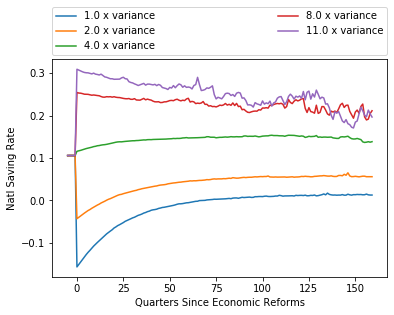

In [11]:
plt.ylabel('Natl Saving Rate')
plt.xlabel('Quarters Since Economic Reforms')
plt.plot(quarters_to_plot,NatlSavingsRates[0],label=str(PermShkVarMultipliers[0]) + ' x variance')
plt.plot(quarters_to_plot,NatlSavingsRates[1],label=str(PermShkVarMultipliers[1]) + ' x variance')
plt.plot(quarters_to_plot,NatlSavingsRates[2],label=str(PermShkVarMultipliers[2]) + ' x variance')
plt.plot(quarters_to_plot,NatlSavingsRates[3],label=str(PermShkVarMultipliers[3]) + ' x variance')
plt.plot(quarters_to_plot,NatlSavingsRates[4],label=str(PermShkVarMultipliers[4]) + ' x variance')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
ncol=2, mode="expand", borderaxespad=0.) #put the legend on top
plt.show(block=False)

The figure shows that, if the rate of growth increases the way Chinese growth did, but is not accompanied by any change in the degree of uncertainty, the model's predicted saving rate declines drastically, from an initial (calibrated) value of about 0.1 (ten percent) to close to zero.  For this model to have any hope of predicting an increase in the saving rate, it is clear that the increase in uncertainty that accompanies the increase in growth will have to be substantial.  

The red line shows that a mere doubling of uncertainty from its baseline value is not enough: The steady state saving rate is still below its slow-growth value.

When we assume that the degree of uncertainty quadruples, the model does finally predict that the new steady-state saving rate will be higher than before, but not much higher, and not remotely approaching 25 percent.

Only when the degree of uncertainty increases by a factor of 8 is the model capable of producing a new equilbrium saving rate in the ballpark of the Chinese value.  

But this is getting close to a point where the model starts to break down (for both numerical and conceptual reasons), as shown by the erratic path of the saving rate when we multiply the initial variance by 11.  

We do not have historical data on the magnitude of permanent income shocks in China in the pre-1978 period; it would be remarkable if the degree of uncertainty increased by such a large amount, but in the absence of good data it is hard to know for sure.  

What the experiment does demonstrate, though, is that it is _not_ the case that "it is easy to explain anything by invoking some plausible but unmeasurable change in uncertainty."  Substantial differences in the degree of permanent (or highly persistent) income uncertainty across countries, across periods, and across people have been measured in the literature, and those differences could in principle be compared to differences in saving rates to get a firmer fix on the quantitative importance of the "precautionary saving" explanation in the Chinese context.